[0, 20, 20, 20, 20, 10, 30]


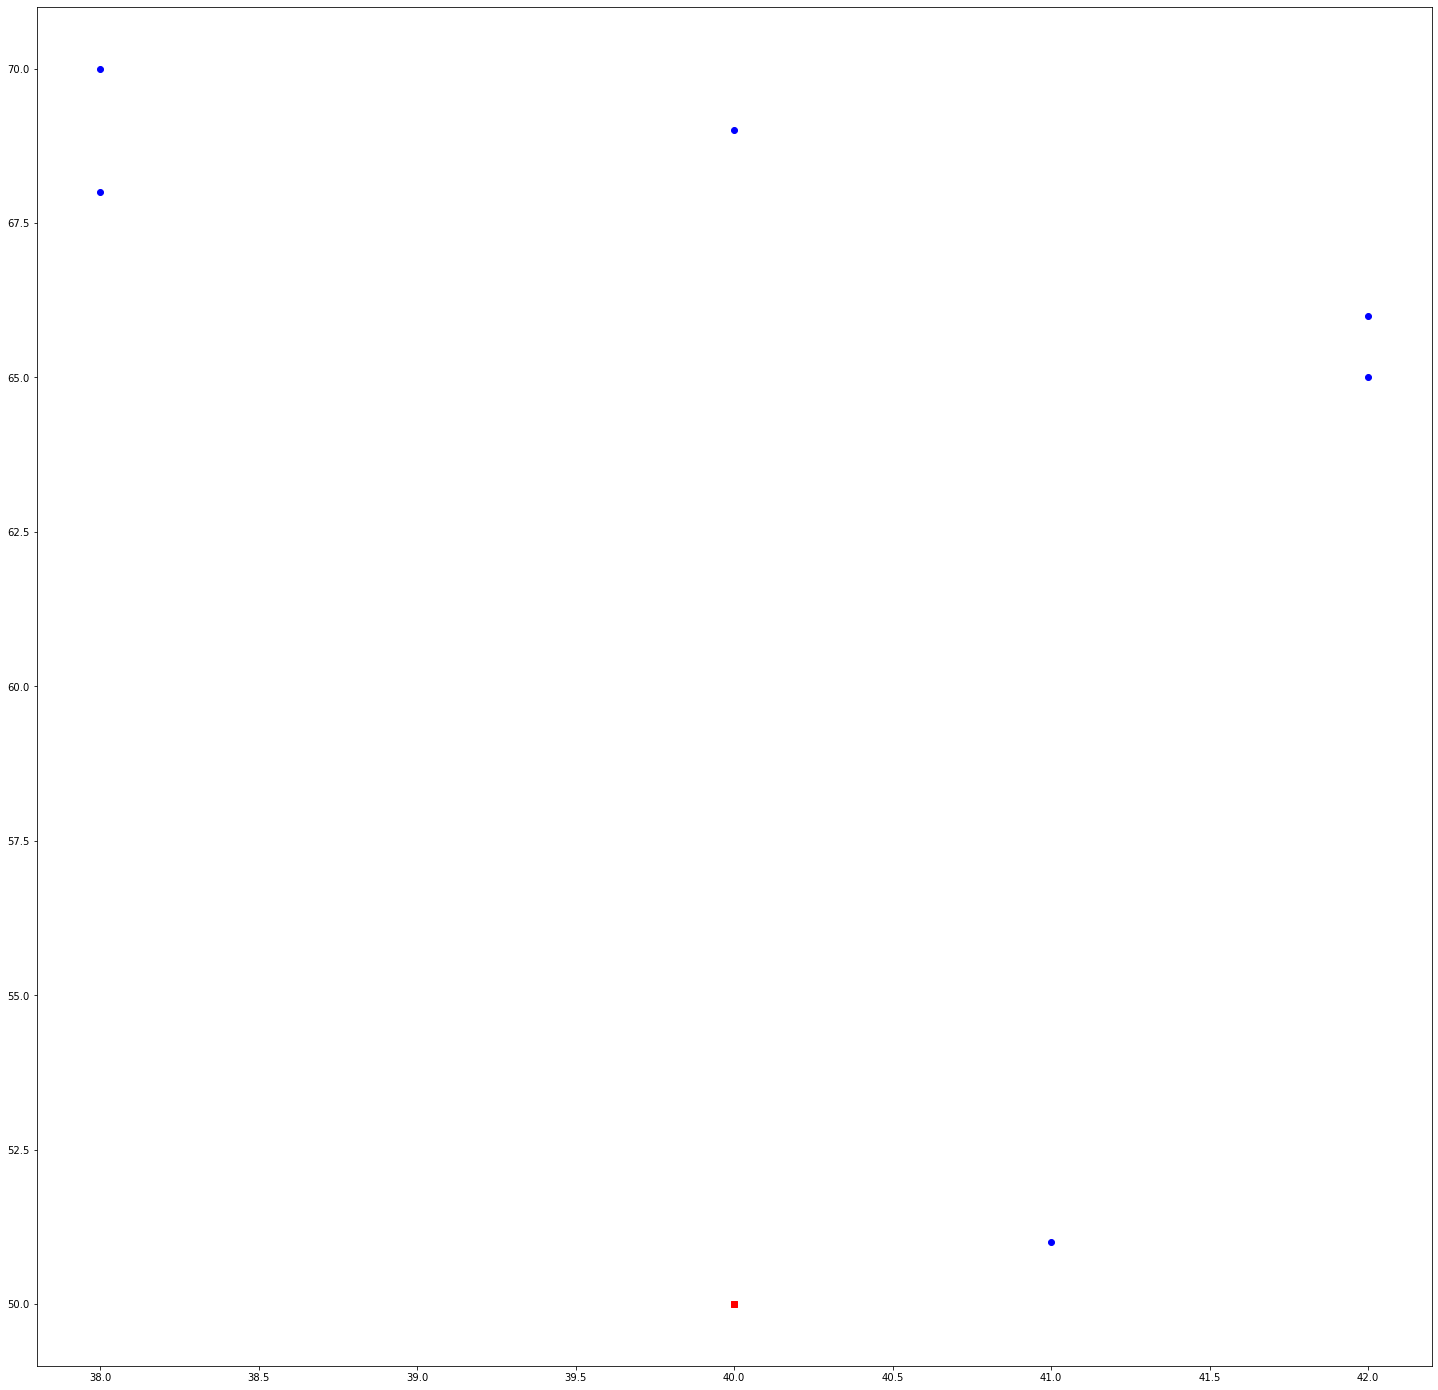

In [25]:
#Import packages for question E
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

#Load the data
data_small = np.loadtxt("data_small.txt", dtype='i')
data_large = np.loadtxt("data_large.txt", dtype='i')

d = data_small

X_COORD = []
for i in d[:,0]:
    X_COORD.append(d[i][1])
    
Y_COORD = []
for i in d[:,0]:
    Y_COORD.append(d[i][2])
    
q = []
for i in d[:,0]:
    q.append(d[i][3])
    
RT = []
for i in d[:,0]:
    RT.append(d[i][4])
    
DT = []
for i in d[:,0]:
    DT.append(d[i][5])
    
ST = []
for i in d[:,0]:
    ST.append(d[i][6])

print(q)
# plot the nodes
plt.scatter(X_COORD[1:], Y_COORD[1:], c='b', marker='o')
plt.scatter(X_COORD[0], Y_COORD[0], c='r', marker='s')
# make the plot larger
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

#Calculate Eucledian distance between the nodes
def c(i,j,data = d):
    distance = np.sqrt((d[i][1] - d[j][1]) ** 2 + (d[i][2] - d[j][2]) ** 2)
    return distance

1
2
3
4
5
6
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 780 rows, 414 columns and 2532 nonzeros
Model fingerprint: 0x3d685488
Variable types: 120 continuous, 294 integer (294 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 582 rows and 198 columns
Presolve time: 0.00s
Presolved: 198 rows, 216 columns, 966 nonzeros
Variable types: 60 continuous, 156 integer (156 binary)

Root relaxation: objective 4.808359e+01, 90 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   48.08359    0   14          -   48.08359      -     -    0s
H    0     0                  

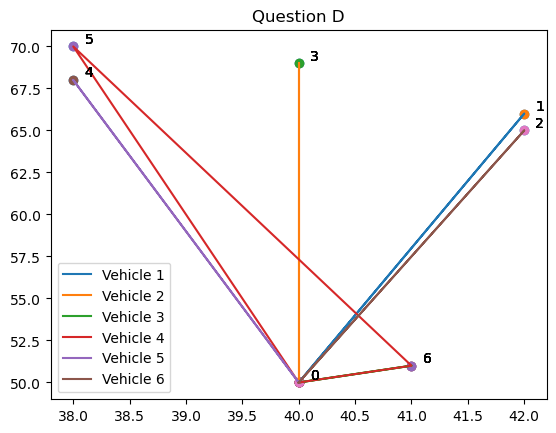

In [29]:
# model
m3 = Model('SDCVRP')

# capacity per vehicle and number of vehicles
capacity_per_vehicle = 20
number_of_vehicles = 6
# demand
Demand = []
for i in d[:,0]:
    Demand.append(d[i][3])

# sets
K = range(len(d))
V = range(number_of_vehicles)
M = 10000
N = range(1,len(d))
A = {(i,j) for i in K for j in K if i != j}
C = {(i, j) : np.hypot(X_COORD[i] - X_COORD[j], Y_COORD[i] - Y_COORD[j]) for i, j in A}
for i in N:
    print(i)

# variables
x = m3.addVars(K , K, V, vtype=GRB.BINARY, name='x')
u = m3.addVars(K, V , vtype=GRB.CONTINUOUS, name='u')
q = m3.addVars(N, V , vtype=GRB.CONTINUOUS, name='q')
t = m3.addVars(K, V , vtype=GRB.CONTINUOUS, name='t')

# objective
m3.setObjective(quicksum(c(i,j) * x[i,j,v] for i in K for j in K for v in V), GRB.MINIMIZE)
m3.update()

# inequality that allows each vehicle to leave the depot once
m3.addConstrs(quicksum(x[0,j,v] for j in N) <= 1 for v in V)
m3.update()

# assure that the vehicle that enters a node also leaves it
m3.addConstrs(quicksum(x[i,j,v] for i in K) == quicksum(x[j,i,v] for i in K) for j in N for v in V)
m3.update()

# Inequalities (4), containing variables ,i u are load balance constraintscontain load variableswith additional index k compared to vrp
m3.addConstrs(u[i,v] + q[j,v] - capacity_per_vehicle * (1 - x[i,j,v]) <= u[j,v] for i in K for j in N for v in V if i != j)
m3.update()

# all vehicle loads at the depot are zero
m3.addConstrs(u[0,v] == 0 for v in V)
m3.update()

# assure that partial deliveries will meet demand of each costumer
m3.addConstrs(quicksum(q[i,v] for v in V) == Demand[i] for i in N)
m3.update()

# Because all loads on each route must respect vehicle capacity, inequalities (14) are introduced
m3.addConstrs(0 <= q[i,v] for i in N for v in V)
m3.addConstrs(q[i,v] <= u[i,v] for i in N for v in V)
m3.addConstrs(u[i,v] <= capacity_per_vehicle for i in N for v in V)
m3.update()

# If vehicle k does not serve customer i , i.e. there is no travel of this vehicle from the location of this customer, the corresponding partial delivery k Qi must
# equal to 0. On the contrary, if partial delivery is positive for vehicle k , it must leave customer i on this route. 
m3.addConstrs(0 <= q[i,v] for i in N for v in V)
m3.addConstrs(q[i,v] <= Demand[i] * quicksum(x[i,j,v] for j in K) for i in N for v in V)
m3.update()

# make sure that the vehicle does not stay in a node
m3.addConstrs(x[i,i,v] == 0 for i in K for v in V)
m3.update()

# time window constraints
m3.addConstrs((t[i,v] >= RT[i]) for i in N for v in V) 
m3.addConstrs((t[i,v] <= DT[i]) for i in N for v in V)
m3.addConstrs((t[i,v]+ c(i,j) + ST[i] - M*(1-x[i,j,v]) <= t[j,v]) for i in K for j in K if i != 0 and j != 0 for v in V)

# model solution
#m3.Params.MIPGap = 0.1 # optimality gap
m3.Params.TimeLimit = 60 * 10 # number of seconds the code will run
m3.optimize()

if m3.status == GRB.Status.OPTIMAL:
        
    Loc_visited = [[] for v in V]
    Route = [[] for v in V]
    Time = [[] for v in V]
    Load = [[] for v in V]
    Route_xcoords = [[] for v in V]
    Route_ycoords = [[] for v in V]

    for v in V:
        for i in K:
            for j in K:
                if x[i,j,v].x == 1:
                    Loc_visited[v].append(j)

        z = 0
        while (len(Route[v]) < len(Loc_visited[v])+1):
            for i in K:
                for j in K:
                    if x[i,j,v].x == 1:
                        if (i in K) & (len(Route[v])==0):
                            Route[v].append(i)        
                        if (i == Route[v][-1]) & (j == Route[v][0]):
                            Route[v].append(j)  
                        if (i == Route[v][-1]) & (j not in Route[v]):
                            Route[v].append(j)

            z = z + 1
            if z > 500:
                print('Vehicle is not used in this problem')
                break
                
    for v in V:
        for w in Route[v]:
            Time[v].append(int(t[w, v].x))
            Time[v][0] = 0
    
    for v in V:
        for r in range(len(Route[v])):
            if r == 0:
                demand_route = 0
                for r in (Route[v]):
                    demand_route += Demand[r]
                Load[v].append(demand_route)
            else:
                Load[v].append(Load[v][r-1] - Demand[Route[v][r]])
        print('Vehicle:  ',v + 1,'\nRoute:    ',Route[v],'\nVeh Load: ',Load[v],'\n','\nTime of Arrival: ', Time[v])    
    
    print('Total distance travelled:     %.4f' % m3.objVal)

# Plot
    
    origin_x = [X_COORD[0]]
    origin_y = [Y_COORD[0]]
    plt.style.use('default')

    for v in V:
        Route_xcoords[v] = [X_COORD[p] for p in Route[v]]
        Route_ycoords[v] = [Y_COORD[p] for p in Route[v]]
    
    for v in V:
        for p in K:
            if r == Route[v][0]:
                plt.annotate('Start/finish',(X_COORD[p], Y_COORD[p]), xytext=(X_COORD[p]+0.1, Y_COORD[p]+0.2))
            else:
                plt.annotate(p ,(X_COORD[p], Y_COORD[p]), xytext=(X_COORD[p]+0.1, Y_COORD[p]+0.2))

    plt.scatter(X_COORD, Y_COORD)
    
    for v in V:
        plt.scatter(Route_xcoords[v], Route_ycoords[v])
        plt.plot(Route_xcoords[v], Route_ycoords[v], label = f'Vehicle {v + 1}')
    
    plt.title('Question D')
    plt.legend(loc='lower left')
    plt.show()

else:
    print('\nNo feasible solution found')


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 6), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 5)]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

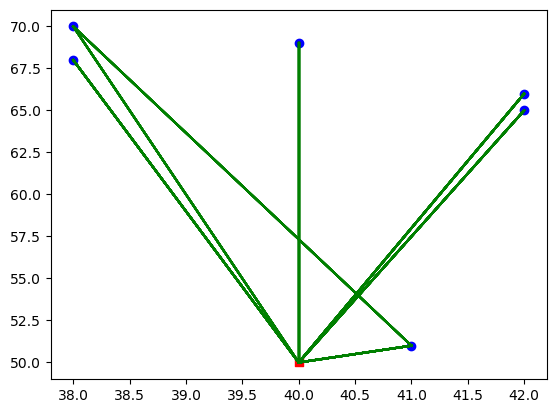

In [30]:
# plotting and determing the solution values

# determining active arcs
active_arcs = []
for i in K:
    for j in K:
        for v in V:
            if x[i,j,v].x > 0.9:
                active_arcs.append((i,j))

print(active_arcs)


# make a matrix of the solution for x
x_sol = []
for i in K:
    for j in K:
        for v in V:
            x_sol.append(x[i,j,v].x)

print(x_sol)

# make a matrix of the solution for u
u_sol = []
for i in K:
    for v in V:
        u_sol.append(u[i,v].x)

print(u_sol)

# make a matrix of the solution for q
q_sol = []
for i in N:
    for v in V:
        q_sol.append(q[i,v].x)

print(q_sol)

# plot the solution
plt.scatter(X_COORD[1:], Y_COORD[1:], c='b', marker='o')
plt.scatter(X_COORD[0], Y_COORD[0], c='r', marker='s')
for i in active_arcs:
    for j in active_arcs:
        plt.plot([X_COORD[i[0]], X_COORD[i[1]]], [Y_COORD[i[0]], Y_COORD[i[1]]], c='g')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

[0, 40, 50, 20, 20, 10, 10, 30, 40, 20, 10, 10, 10, 40, 20, 10, 10, 30, 40, 10, 10, 30, 20, 40, 50, 30, 10, 10, 10, 20, 40, 80, 40, 20, 50, 10, 50, 10, 40, 20, 10, 20, 10, 30, 20, 20, 10, 20, 10, 20, 10, 30, 20, 20]


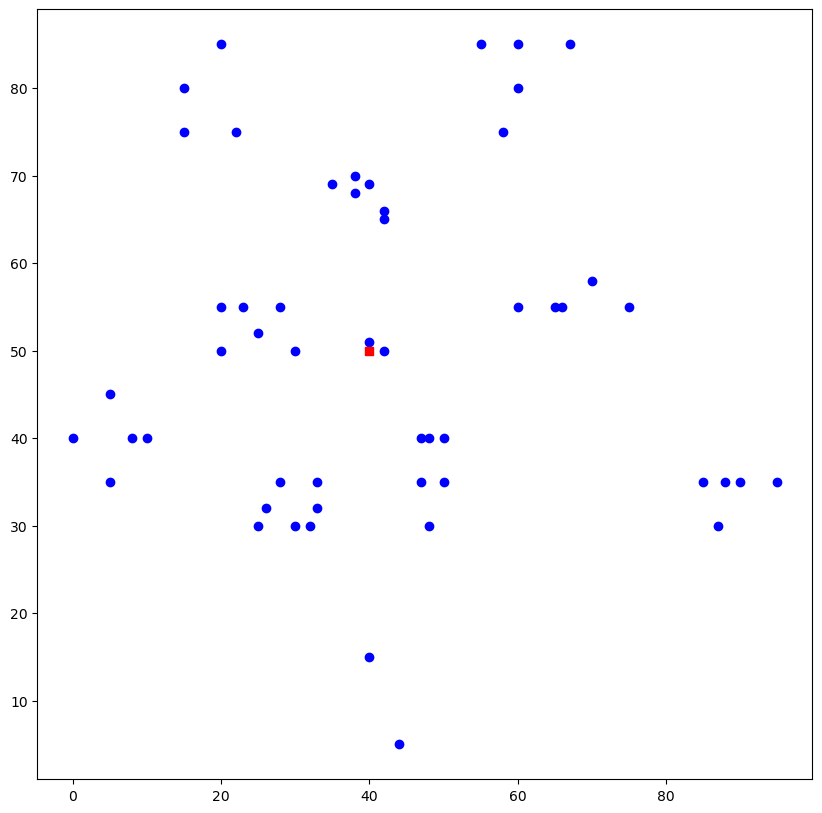

minimum number of vehicles needed to serve all customers due to the capacity of each vehicle:  7


In [31]:
#Import packages for question G
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import math as m

#Load the data
data_small = np.loadtxt("data_small.txt", dtype='i')
data_large = np.loadtxt("data_large.txt", dtype='i')

d = data_large

X_COORD = []
for i in d[:,0]:
    X_COORD.append(d[i][1])
    
Y_COORD = []
for i in d[:,0]:
    Y_COORD.append(d[i][2])
    
q = []
for i in d[:,0]:
    q.append(d[i][3])
    
RT = []
for i in d[:,0]:
    RT.append(d[i][4])
    
DT = []
for i in d[:,0]:
    DT.append(d[i][5])
    
ST = []
for i in d[:,0]:
    ST.append(d[i][6])

print(q)
# plot the nodes
plt.scatter(X_COORD[1:], Y_COORD[1:], c='b', marker='o')
plt.scatter(X_COORD[0], Y_COORD[0], c='r', marker='s')
# make the plot larger
plt.rcParams["figure.figsize"] = (25,25)
plt.show()

#Calculate Eucledian distance between the nodes
def c(i,j,data = d):
    distance = np.sqrt((d[i][1] - d[j][1]) ** 2 + (d[i][2] - d[j][2]) ** 2)
    return distance

# capacity per vehicle and number of vehicles
capacity_per_vehicle = 200

# demand
Demand = []
for i in d[:,0]:
    Demand.append(d[i][3])

# calculate the minimum number of vehicles needed to serve all customers due to the capacity of each vehicle 
total = 0
 
# Iterate each element in list
# and add them in variable total
for ele in range(0, len(Demand)):
    total = total + Demand[ele]
 
# printing total value
print("minimum number of vehicles needed to serve all customers due to the capacity of each vehicle: ", m.ceil(total/capacity_per_vehicle))

# number of vehicles
number_of_vehicles = m.ceil(total/capacity_per_vehicle)

In [32]:
# model
m3 = Model('SDCVRP G')

# sets
K = range(len(d))
V = range(number_of_vehicles)
M = 10000
N = range(1,len(d))
A = {(i,j) for i in K for j in K if i != j}
C = {(i, j) : np.hypot(X_COORD[i] - X_COORD[j], Y_COORD[i] - Y_COORD[j]) for i, j in A}
for i in N:
    print(i)

# variables
x = m3.addVars(K , K, V, vtype=GRB.BINARY, name='x')
u = m3.addVars(K, V , vtype=GRB.CONTINUOUS, name='u')
q = m3.addVars(N, V , vtype=GRB.CONTINUOUS, name='q')
t = m3.addVars(K, V , vtype=GRB.CONTINUOUS, name='t')

# objective
m3.setObjective(quicksum(c(i,j) * x[i,j,v] for i in K for j in K for v in V), GRB.MINIMIZE)
m3.update()

# inequality that allows each vehicle to leave the depot once
m3.addConstrs(quicksum(x[0,j,v] for j in N) <= 1 for v in V)
m3.update()

# assure that the vehicle that enters a node also leaves it
m3.addConstrs(quicksum(x[i,j,v] for i in K) == quicksum(x[j,i,v] for i in K) for j in N for v in V)
m3.update()

# Inequalities (4), containing variables ,i u are load balance constraintscontain load variableswith additional index k compared to vrp
m3.addConstrs(u[i,v] + q[j,v] - capacity_per_vehicle * (1 - x[i,j,v]) <= u[j,v] for i in K for j in N for v in V if i != j)
m3.update()

# all vehicle loads at the depot are zero
m3.addConstrs(u[0,v] == 0 for v in V)
m3.update()

# assure that partial deliveries will meet demand of each costumer
m3.addConstrs(quicksum(q[i,v] for v in V) == Demand[i] for i in N)
m3.update()

# Because all loads on each route must respect vehicle capacity, inequalities (14) are introduced
m3.addConstrs(0 <= q[i,v] for i in N for v in V)
m3.addConstrs(q[i,v] <= u[i,v] for i in N for v in V)
m3.addConstrs(u[i,v] <= capacity_per_vehicle for i in N for v in V)
m3.update()

# If vehicle k does not serve customer i , i.e. there is no travel of this vehicle from the location of this customer, the corresponding partial delivery k Qi must
# equal to 0. On the contrary, if partial delivery is positive for vehicle k , it must leave customer i on this route. 
m3.addConstrs(0 <= q[i,v] for i in N for v in V)
m3.addConstrs(q[i,v] <= Demand[i] * quicksum(x[i,j,v] for j in K) for i in N for v in V)
m3.update()

# make sure that the vehicle does not stay in a node
m3.addConstrs(x[i,i,v] == 0 for i in K for v in V)
m3.update()

# time window constraints
m3.addConstrs((t[i,v] >= RT[i]) for i in N for v in V) 
m3.addConstrs((t[i,v] <= DT[i]) for i in N for v in V)
m3.addConstrs((t[i,v]+ c(i,j) + ST[i] - M*(1-x[i,j,v]) <= t[j,v]) for i in K for j in K if i != 0 and j != 0 for v in V)

# model solution
#m3.Params.MIPGap = 0.1 # optimality gap
m3.Params.TimeLimit = 60 * 10 # number of seconds the code will run
m3.optimize()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license